# ETL y EDA sobre el dataset de steam_games para el Proyecto ML Ops de Henry

## Problema de negocio:
Se solicita predecir el precio de un videojuego. 

## Objetivos:
Habiendo probado la primera limpieza de los datos (utilizada exitósamente sobre el main.py), debemos investigar las relaciones que hay entre las variables del dataset, comprobar si hay outliers o anomalías, y verificar patrones interesantes que valgan la pena explorar para crear un modelo predictivo eficiente. Este deberá basarse en características como Género, Año, Metascore o cualquiera de aquellas que resulten adecuadas.

### Describimos las variables que conforman el dataframe

* publisher: Empresa publicadora del contenido
* genres: Género del contenido
* app_name: Nombre del contenido
* title: Título del contenido
* url: URL de publicación del contenido
* release_date: Fecha de lanzamiento
* tags: Etiquetas de contenido
* discount_price: Precio de descuento
* reviews_url: Reviews de contenido
* specs: Especificaciones
* price: Precio del contenido
* early_access: Acceso temprano
* id: Identificador único de contenido
* developer: Desarrollador
* sentiment: Análisis de sentimientos
* metascore: Score por metacritic

### Generación del primer Data Wrangling.

In [1]:
# Importamos de las librerías necesarias
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

In [2]:
# Recuperamos los datos desde el archivo .json provisto
dataset = []
with open('dataset/steam_games.json') as f:
    dataset.extend(ast.literal_eval(line) for line in f)
    
# Creamos el dataframe a partir del dataset obtenido
data = pd.DataFrame(dataset)

In [3]:
# Verificamos la estructura de nuestro dataframe
data.shape

(32135, 16)

In [4]:
# Verificamos cómo está conformado
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [5]:
# Hacemos una comprobación de los valores nulos
data.isnull().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [6]:
# Reubicamos la variable 'id' para un mejor lectura
cols = list(data.columns)
cols.remove('id')
cols = ['id'] + cols
data = data[cols]

In [7]:
# Verificamos si la variable 'id' contiene nulos
filas_null = data[data['id'].isna()]
filas_null

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
74,NaN,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,14.99,NaN,NaN,19.99,False,NaN,NaN,NaN
30961,NaN,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [8]:
# Identificamos las filas duplicadas en la variable 'id'
filas_dup = data[data.duplicated('id', keep=False)]
filas_dup

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
74,NaN,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,14.99,NaN,NaN,19.99,False,NaN,NaN,NaN
13894,612880,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,Machine Games,Mostly Positive,86
14573,612880,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,Machine Games,Mostly Positive,86
30961,NaN,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [9]:
# Eliminamos las filas con nulos y duplicadas en la variable 'id'
data_con_valores_nuevos = data.copy()
data_con_valores_nuevos.drop([74, 14573], inplace=True)
data_con_valores_nuevos.reset_index(drop=True, inplace=True)

In [10]:
# Adecuamos el valor nulo en la variable 'id' en correlación a los demás valores existentes
filas_con_nulos = data_con_valores_nuevos[data_con_valores_nuevos['id'].isnull()].index
valores_no_nulos_ordenados = data_con_valores_nuevos.dropna(subset=['id']).sort_values('id')['id'].unique()
data_con_valores_nuevos.loc[filas_con_nulos, 'id'] = valores_no_nulos_ordenados[:len(filas_con_nulos)]

In [11]:
# Verificamos nuestro nuevo orden de variables y comprobamos la composición de nuestro dataframe
data_con_valores_nuevos

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,761140,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,Kotoshiro,NaN,NaN
1,643980,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,Secret Level SRL,Mostly Positive,NaN
2,670290,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,Poolians.com,Mostly Positive,NaN
3,767400,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,彼岸领域,NaN,NaN
4,773570,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,773640,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,"Nikita ""Ghost_RUS""",NaN,NaN
32129,733530,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,Sacada,NaN,NaN
32130,610660,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,Laush Dmitriy Sergeevich,NaN,NaN
32131,658870,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,"xropi,stev3ns",1 user reviews,NaN


* Hasta aquí nos hemos asegurado de que el dataframe inicial contenga la información adecuada para comenzar con un análisis sin escollos. Hemos visto que unas de las variables de interés, 'metascore', del total de filas del dataframe, contiene casi un 95% de valores nulos, y que la variable 'id' contenía valores duplicados y nulos, que se han corregido y a su vez fue recolocada para poder utilizarla como identificador único en el caso de querer relacionar la presente información con otros datasets en un análisis ulterior.   

### Distribución de los datos

In [12]:
# Adecuación y limpieza del dataframe
data_steam = data_con_valores_nuevos.copy()
data_steam['release_date'] = pd.to_datetime(data_steam['release_date'], errors='coerce')
data_steam['metascore'] = pd.to_numeric(data_steam['metascore'], errors='coerce')
data_steam['price'] = pd.to_numeric(data_steam['price'], errors='coerce')
reemplazar_valores = {'publisher': '', 'genres': '', 'tags': '', 'discount_price': 0,
                      'specs': '', 'reviews_url': '', 'app_name': '', 'title': '',
                       'id': '', 'sentiment': '', 'developer': ''}
data_steam.fillna(value=reemplazar_valores, inplace=True)
data_steam = data_steam.dropna(subset=['price'])
data_steam = data_steam.dropna(subset=['release_date'])
data_steam = data_steam.dropna(subset=['metascore'])
data_steam.reset_index(drop=True, inplace=True)

In [13]:
# Inspeccionamos la variable 'price', que más tarde usaremos en nuestro modelo predictor
data_steam['price'].unique()

array([ 9.99,  6.99,  4.99, 19.99,  7.49, 14.99,  8.99, 12.99,  5.99,
        7.99,  2.99, 15.99,  1.99, 29.99, 39.99, 24.99,  0.99, 18.99,
       11.99, 13.99,  3.99, 14.95, 59.99, 13.98, 49.99, 34.99, 17.99,
       10.99, 44.99, 16.99, 26.99,  4.68, 19.95, 99.99, 87.94, 20.99,
       12.89,  1.  , 12.  , 13.37, 15.  , 59.95, 54.99])

In [14]:
# Hacemos limpieza de las variables numéricas
data_steam['price'] = data_steam['price'].astype(float)
data_steam['metascore'] = data_steam['metascore'].replace('NA', np.nan)
data_steam = data_steam.dropna(subset=['metascore'])
data_steam['metascore'] = data_steam['metascore'].astype(int)

In [15]:
# Definimos una función para extraer los datos de las variables que contienen listas
def extraer_listas(df, columns_to_explode):
    data_exploded = df.copy()
    for column in columns_to_explode:
        data_exploded = data_exploded.explode(column)
    data_exploded.reset_index(drop=True, inplace=True)
    return data_exploded

In [16]:
# Seleccionamos y explotamos las variables de interés
col_listas = ['genres', 'tags', 'specs']
data_steam_final = extraer_listas(data_steam, col_listas)

In [17]:
# Contamos los valores únicos por variable
data_steam_final.nunique()

id                2453
publisher          935
genres              13
app_name          2453
title             2453
url               2454
release_date      1605
tags               322
discount_price       4
reviews_url       2454
specs               28
price               43
early_access         2
developer         1537
sentiment           19
metascore           69
dtype: int64

In [18]:
# Mostramos el dataframe final
data_steam_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310824 entries, 0 to 310823
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              310824 non-null  object        
 1   publisher       310824 non-null  object        
 2   genres          310824 non-null  object        
 3   app_name        310824 non-null  object        
 4   title           310824 non-null  object        
 5   url             310824 non-null  object        
 6   release_date    310824 non-null  datetime64[ns]
 7   tags            310824 non-null  object        
 8   discount_price  310824 non-null  float64       
 9   reviews_url     310824 non-null  object        
 10  specs           310824 non-null  object        
 11  price           310824 non-null  float64       
 12  early_access    310824 non-null  bool          
 13  developer       310824 non-null  object        
 14  sentiment       310824 non-null  obj

* Con la vista puesta en normalizar los datos entre las distintas variables, se decidió eliminar los datos nulos o faltantes, los cuales eran una constante en todo el dataframe, adecuando también el tipo de dato correcto para cada columna. Asmimismo, se entrajeron los datos contenidos dentro de listas en las variables 'genres', 'specs' y 'tags'. Luego, llegamos al resultado de emparejar la información en todas las variables, logrando que todos los valores coincidan sin nulos o faltantes. 

### Análisis de Componentes Principales (PCA).

In [19]:
# Importación de las librerías necesarias
import category_encoders as ce
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

In [20]:
data_steam_metascore = data_steam_final.copy()
# Codificamos las variables categóricas a numéricas para una mejor utilización del modelo
a_numérica = ce.OrdinalEncoder(cols=['id', 'publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'discount_price', 'reviews_url', 'specs', 'price',
       'early_access', 'developer', 'sentiment', 'metascore'])

# Definimos un dataframe para el cálculo del PCA 
data_steam_pca = a_numérica.fit_transform(data_steam_metascore)
data_steam_pca

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,1,1,1,1,1,1,-1.0,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,-1.0,1,1,1,2,1,1,1,1,1
2,1,1,1,1,1,1,-1.0,1,1,1,3,1,1,1,1,1
3,1,1,1,1,1,1,-1.0,2,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,-1.0,2,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310819,2453,1,1,2453,2453,2454,-1.0,35,1,2454,2,1,1,1,3,17
310820,2453,1,1,2453,2453,2454,-1.0,35,1,2454,3,1,1,1,3,17
310821,2453,1,1,2453,2453,2454,-1.0,50,1,2454,1,1,1,1,3,17
310822,2453,1,1,2453,2453,2454,-1.0,50,1,2454,2,1,1,1,3,17


In [21]:
# Entrenamos el modelo PCA con escalado de los datos y lo agrupamos en un pipeline
pipe_pca = make_pipeline(MinMaxScaler(), PCA())
pipe_pca.fit(data_steam_pca)
modelo_pca = pipe_pca.named_steps['pca']

[0.49856719 0.63439321 0.70979482 0.78289961 0.84386607 0.90045483
 0.94246878 0.98240117 0.99267483 0.99900865 0.99954647 0.99999597
 1.         1.         1.         1.        ]


Text(0, 0.5, '% Varianza Acumulada')

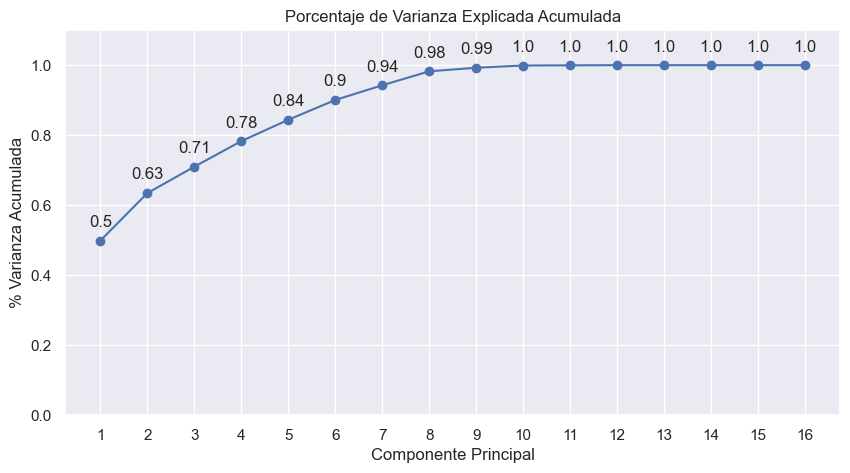

In [22]:
# Calculamos el porcentaje de varianza explicada acumulada
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print(prop_varianza_acum)

# Lo mostramos en un gráfico
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(np.arange(len(data_steam_pca.columns)) + 1, prop_varianza_acum, marker = 'o')
for x, y in zip(np.arange(len(data_steam_pca.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de Varianza Explicada Acumulada')
ax.set_xlabel('Componente Principal')
ax.set_ylabel('% Varianza Acumulada')

In [23]:
# Definimos ahora un nuevo dataframe para mostrar el trabajo del PCA en columnas
pca_df = data_steam_pca
pca_df2 = pca_df
pca_df = MinMaxScaler().fit_transform(pca_df)
pca_df = pd.DataFrame(pca_df,columns=pca_df2.columns).set_index(pca_df2.index)
pca_df

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.037037,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.074074,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003115,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003115,0.0,0.0,0.037037,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310819,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.105919,0.0,1.0,0.037037,0.0,0.0,0.0,0.111111,0.235294
310820,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.105919,0.0,1.0,0.074074,0.0,0.0,0.0,0.111111,0.235294
310821,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.152648,0.0,1.0,0.000000,0.0,0.0,0.0,0.111111,0.235294
310822,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.152648,0.0,1.0,0.037037,0.0,0.0,0.0,0.111111,0.235294


In [24]:
# Procedemos a aplicar el PCA y calcular los porcentajes en las muestras explicadas anteriormente
pca = PCA(n_components=16)
principalComponents = pca.fit_transform(pca_df)
principalComp_Df = pd.DataFrame(data = principalComponents, columns = ['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10','pca11','pca12','pca13','pca14','pca15','pca16']).set_index(pca_df.index)
print("Forma del dataframe de los Componentes Principales", principalComp_Df.shape)
explicacion = pca.explained_variance_ratio_
print(explicacion)
print('suma:', sum(explicacion[:16]))

Forma del dataframe de los Componentes Principales (310824, 16)
[4.98567193e-01 1.35826021e-01 7.54016056e-02 7.31047942e-02
 6.09664601e-02 5.65887581e-02 4.20139449e-02 3.99323960e-02
 1.02736550e-02 6.33382417e-03 5.37820933e-04 4.49498655e-04
 4.02849207e-06 1.18317746e-31 3.91601012e-34 2.05447662e-38]
suma: 0.9999999999999998


In [25]:
# Mostramos el dataframe de PCA logrado
principalComp_Df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16
0,-1.198281,0.136799,-0.313184,0.050208,-0.383854,-0.030593,-0.038343,-0.073747,-0.083236,0.012351,-0.001687,-0.000926,-0.000055,-5.744544e-16,-3.590725e-17,-2.569483e-19
1,-1.198480,0.133903,-0.290980,0.020960,-0.381039,-0.030609,-0.039531,-0.076072,-0.083084,0.011997,-0.001659,-0.000905,-0.000052,-1.716789e-16,-1.070962e-17,-1.249472e-20
2,-1.198678,0.131007,-0.268777,-0.008287,-0.378225,-0.030625,-0.040719,-0.078398,-0.082933,0.011644,-0.001631,-0.000885,-0.000050,-3.199317e-16,-1.999007e-17,-9.644070e-20
3,-1.198279,0.136560,-0.310742,0.052080,-0.383958,-0.030998,-0.038340,-0.073803,-0.083208,0.012365,-0.001689,-0.000926,-0.000055,1.552354e-13,-1.822472e-17,-9.326585e-20
4,-1.198478,0.133664,-0.288538,0.022832,-0.381143,-0.031014,-0.039527,-0.076128,-0.083056,0.012012,-0.001661,-0.000906,-0.000053,-5.110649e-18,1.397670e-18,1.579764e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310819,0.874279,0.925986,-0.124309,0.070249,-0.172977,-0.138062,-0.217956,0.083428,0.030389,0.010416,-0.002437,0.000602,0.000034,-3.563306e-19,-8.535026e-21,5.632849e-22
310820,0.874081,0.923090,-0.102106,0.041001,-0.170162,-0.138079,-0.219143,0.081102,0.030540,0.010062,-0.002409,0.000622,0.000036,-2.581434e-19,-2.533769e-21,5.877442e-22
310821,0.874512,0.925291,-0.109882,0.127578,-0.177350,-0.144126,-0.216712,0.084913,0.030663,0.010982,-0.002491,0.000569,0.000029,-3.594960e-19,-2.995729e-21,9.763558e-22
310822,0.874314,0.922396,-0.087679,0.098330,-0.174536,-0.144142,-0.217900,0.082588,0.030814,0.010628,-0.002462,0.000589,0.000032,-2.613088e-19,3.005528e-21,1.000815e-21


* Este somero análisis de componentes principales, en la idea de que al reducir la dimensionalidad de nuestro dataframe a un 80/85 porciento de explicación con el mínimo de columnas posibles es suficiente a los fines de nuestro mejor análisis de datos, nos lleva a concluir que acotando nuestro dataframe principal a 6 columnas, tendríamos suficientes componentes principales para llevar el estudio de nuestros datos al éxito.

### Análisis de los datos y visualizaciones

In [26]:
# Reducimos las variables del dataframe a las de interés
steam_eda_reduc = data_steam_final.drop(['id', 'publisher', 'app_name', 'url', 'title', 'reviews_url', 'sentiment'], axis=1, inplace=True)
steam_eda_reduc = data_steam_final[data_steam_final['price'] != 0]
steam_eda_reduc['genres'] = steam_eda_reduc['genres'].replace('', np.nan)
steam_eda_reduc = steam_eda_reduc.dropna(subset=['genres'])
steam_eda_reduc.reset_index(drop=True, inplace=True)
steam_eda_reduc.columns

Index(['genres', 'release_date', 'tags', 'discount_price', 'specs', 'price',
       'early_access', 'developer', 'metascore'],
      dtype='object')

##### Nube de palabras para las variables no numéricas

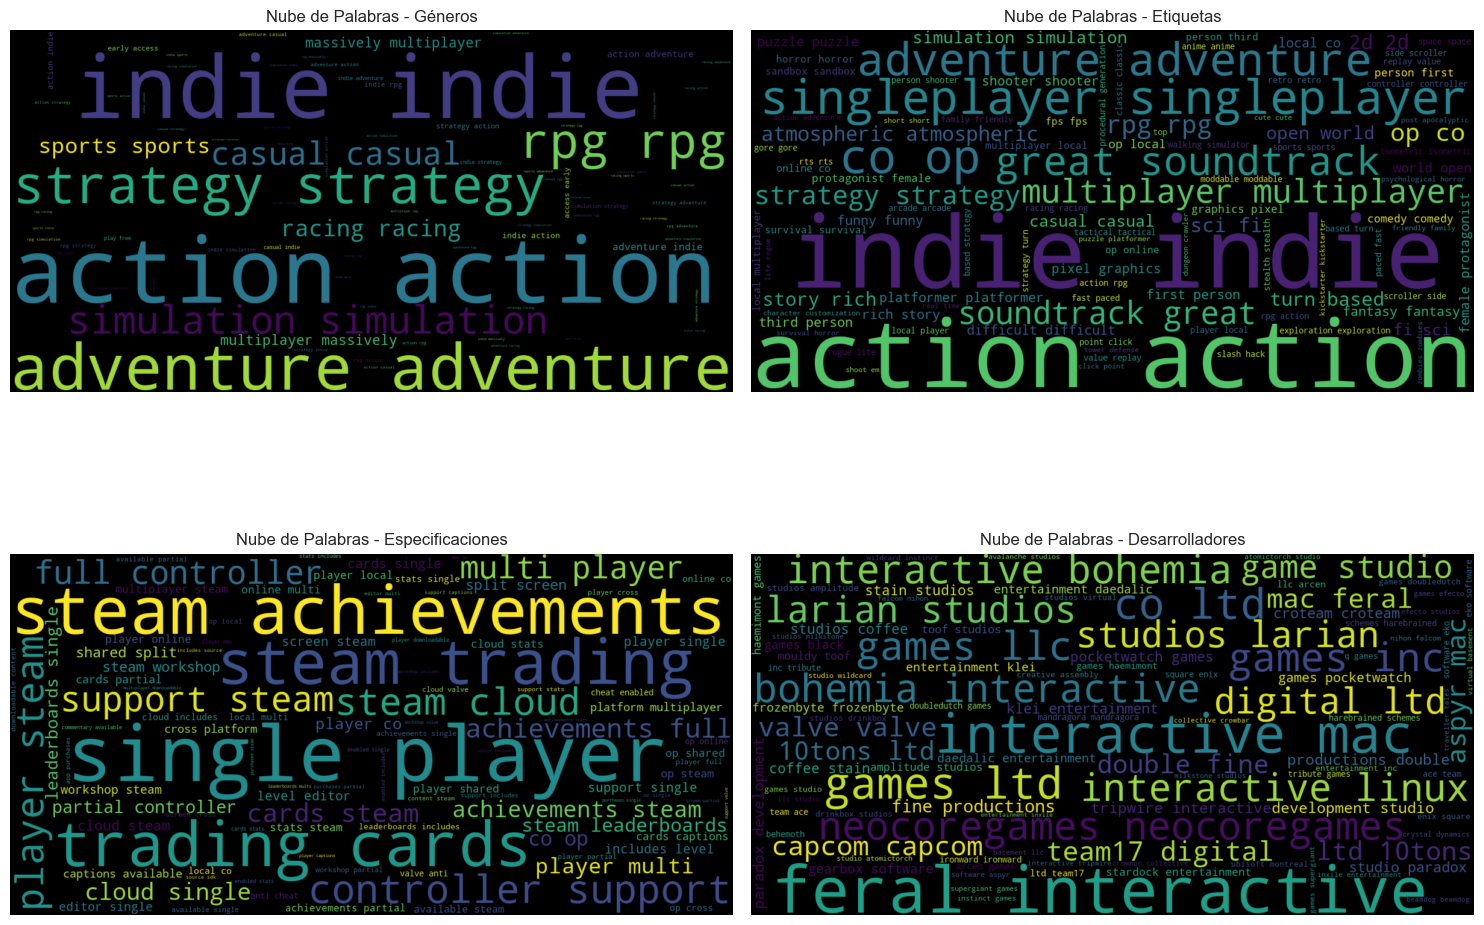

In [27]:
# Creamos los objetos WordCloud para las variables 'genres', 'tags', 'specs' y 'developer'
steam_eda_reduc['genres'] = steam_eda_reduc['genres'].astype(str)
all_genres = ','.join(steam_eda_reduc['genres']).lower()
wordcloud_genres = WordCloud(width=1200, height=600, background_color='black', colormap='viridis', max_words=100).generate(all_genres)
steam_eda_reduc['tags'] = steam_eda_reduc['tags'].astype(str)
all_tags = ','.join(steam_eda_reduc['tags']).lower()
wordcloud_tags = WordCloud(width=1200, height=600, background_color='black', colormap='viridis', max_words=100).generate(all_tags)
steam_eda_reduc['specs'] = steam_eda_reduc['specs'].astype(str)
all_specs = ','.join(steam_eda_reduc['specs']).lower()
wordcloud_specs = WordCloud(width=1200, height=600, background_color='black', colormap='viridis', max_words=100).generate(all_specs)
steam_eda_reduc['developer'] = steam_eda_reduc['developer'].astype(str)
all_developers = ','.join(steam_eda_reduc['developer']).lower()
wordcloud_developers = WordCloud(width=1200, height=600, background_color='black', colormap='viridis', max_words=100).generate(all_developers)
# Definimos subplots con 2 filas y 2 columnas para las nubes de palabras
plt.figure(figsize=(15, 12))
# Subplot 1: Géneros
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_genres, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Géneros')
# Subplot 2: Tags
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Etiquetas')
# Subplot 3: Specs
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_specs, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Especificaciones')
# Subplot 4: Developers
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_developers, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Desarrolladores')
# Ajustamos los subplots para evitar superposición de etiquetas
plt.tight_layout()
# Mostramos el gráfico
plt.show()


* Nótese que entre géneros y etiquetas, Indie y Action mantienen una notable similitud en el primer y segundo puesto, ya no hallándose el mismo patrón para los demás. Ya respecto a las especificaciones, single, player y steam marcan el top 3, mientras que para desarrolladores, al parecer interactive es la palabra más elegida entre ellos.

##### Matriz de correlación entre la variable 'genres' y las demás numéricas

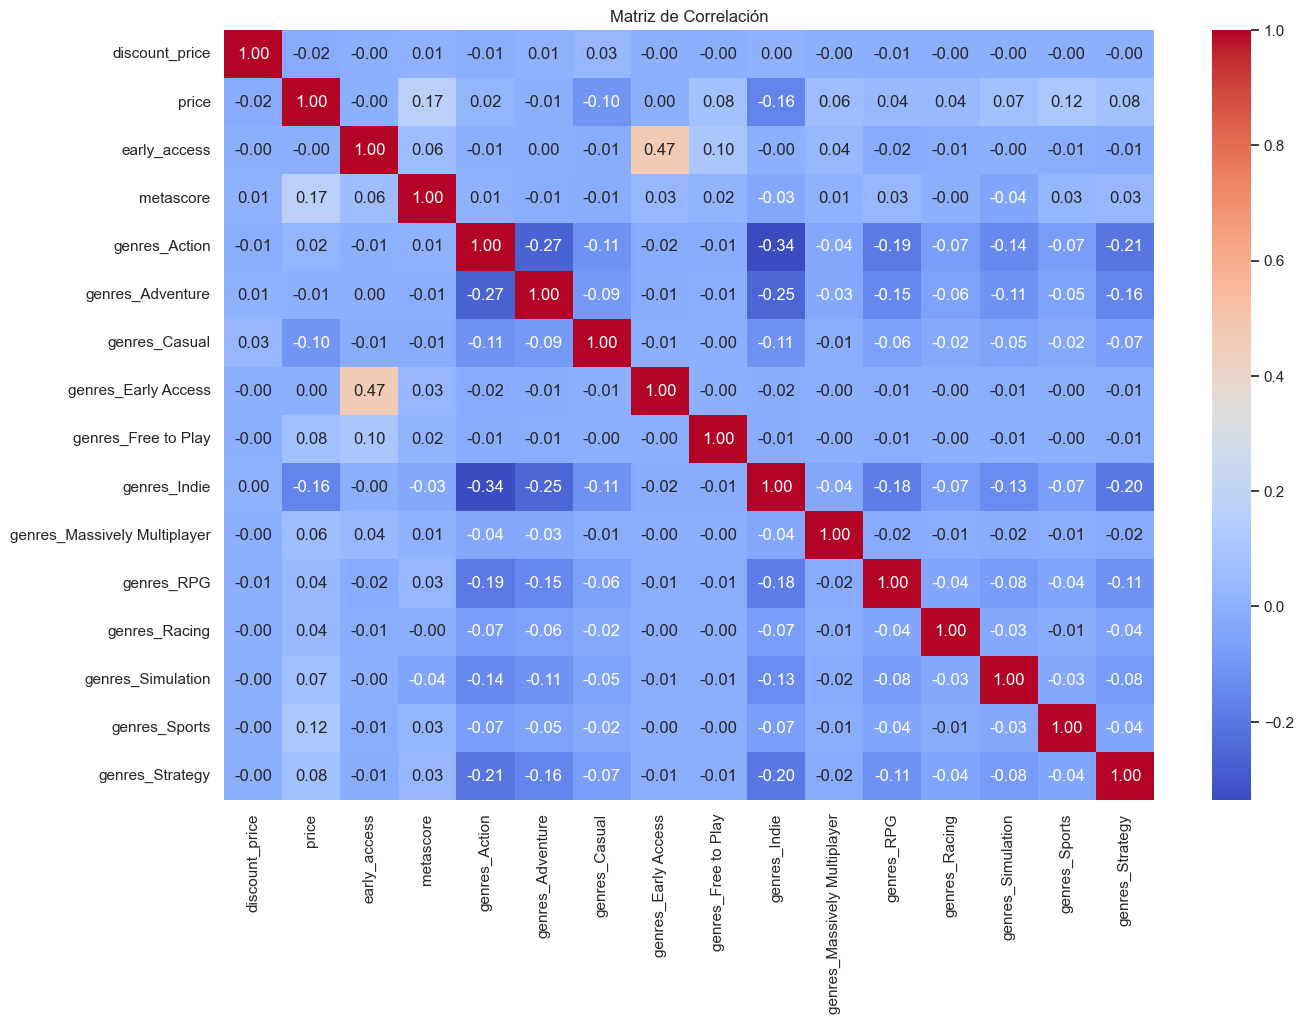

In [28]:
# Definimos una copia del dataframe principal
steam_eda_corr = steam_eda_reduc.copy()
# Codificamos las variables categóricas utilizando one-hot encoding
steam_eda_corr = pd.get_dummies(steam_eda_corr, columns=['genres'])
# Calculamos la matriz de correlación
correlation_matrix = steam_eda_corr.corr()
# Creamos la visualización de la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

* Interesante es darnos cuenta, luego de analizar la presente matriz, que la variable 'early_access' comparte una correlación por debajo del 0.5 respecto del género denominado (uno pensaría de inmediato que debería ser una correlación perfecta) Early Access, sobresaliendo luego las correlaciones -aunque bajas, presentes- entre los géneros de acción e indie, acción y aventuras e indie y aventuras.

##### Crosstab para las variables 'genres' y 'early_access'

In [29]:
# Creamos un dataframe para revisión
pd.crosstab(index=steam_eda_reduc['genres'], columns=steam_eda_reduc['early_access'])

early_access,False,True
genres,,
Action,80865,291
Adventure,51978,240
Casual,11144,0
Early Access,0,291
Free to Play,124,51
Indie,74864,291
Massively Multiplayer,1197,51
RPG,29351,0
Racing,4760,0


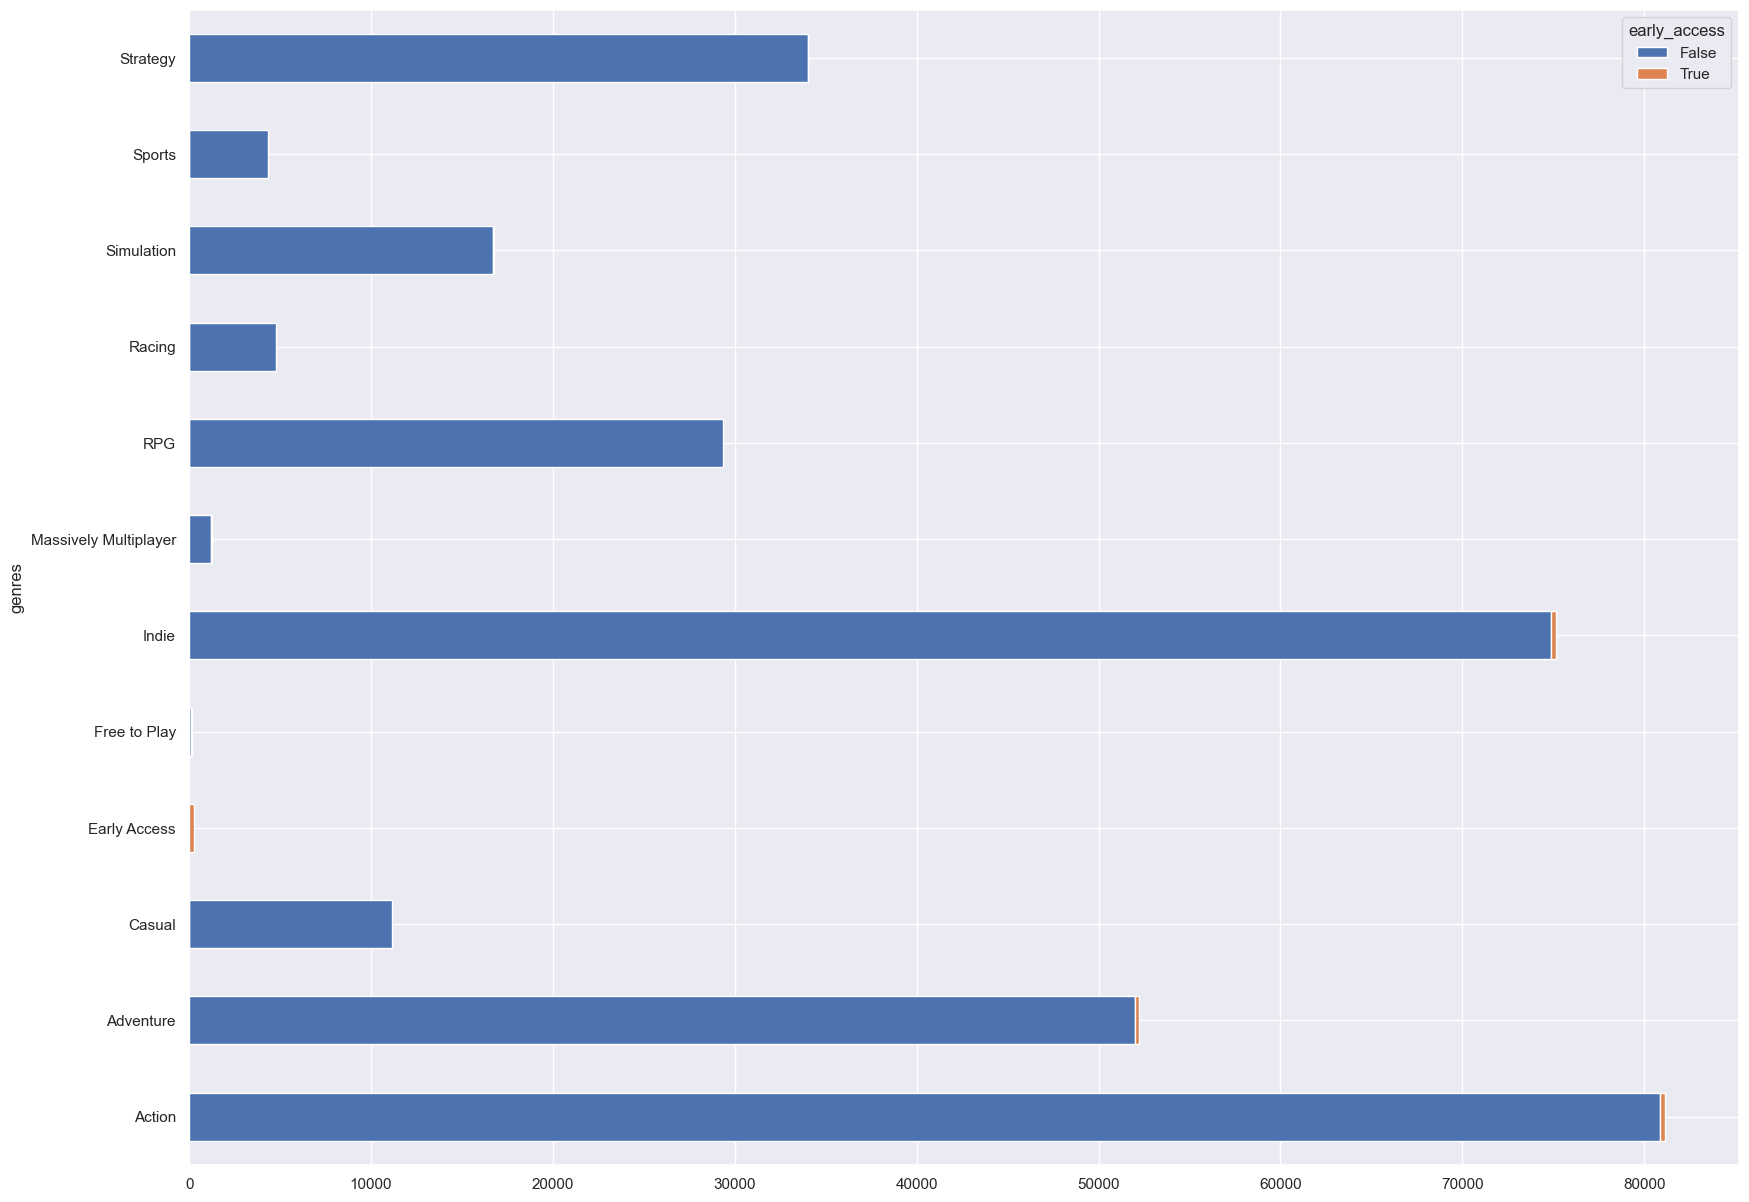

In [30]:
# Creamos la visualización de las variables detalladas
pd.crosstab(index=steam_eda_reduc['genres'], columns=steam_eda_reduc['early_access']).plot.barh(stacked=True, figsize=(20, 15))
plt.show()

* Sin más, al parecer la plataforma de juegos no es partidaria de accesos tempranos en casi ninguno de sus géneros.

##### Catplot para las variables 'genres' y 'release_date'

<Figure size 1200x1200 with 0 Axes>

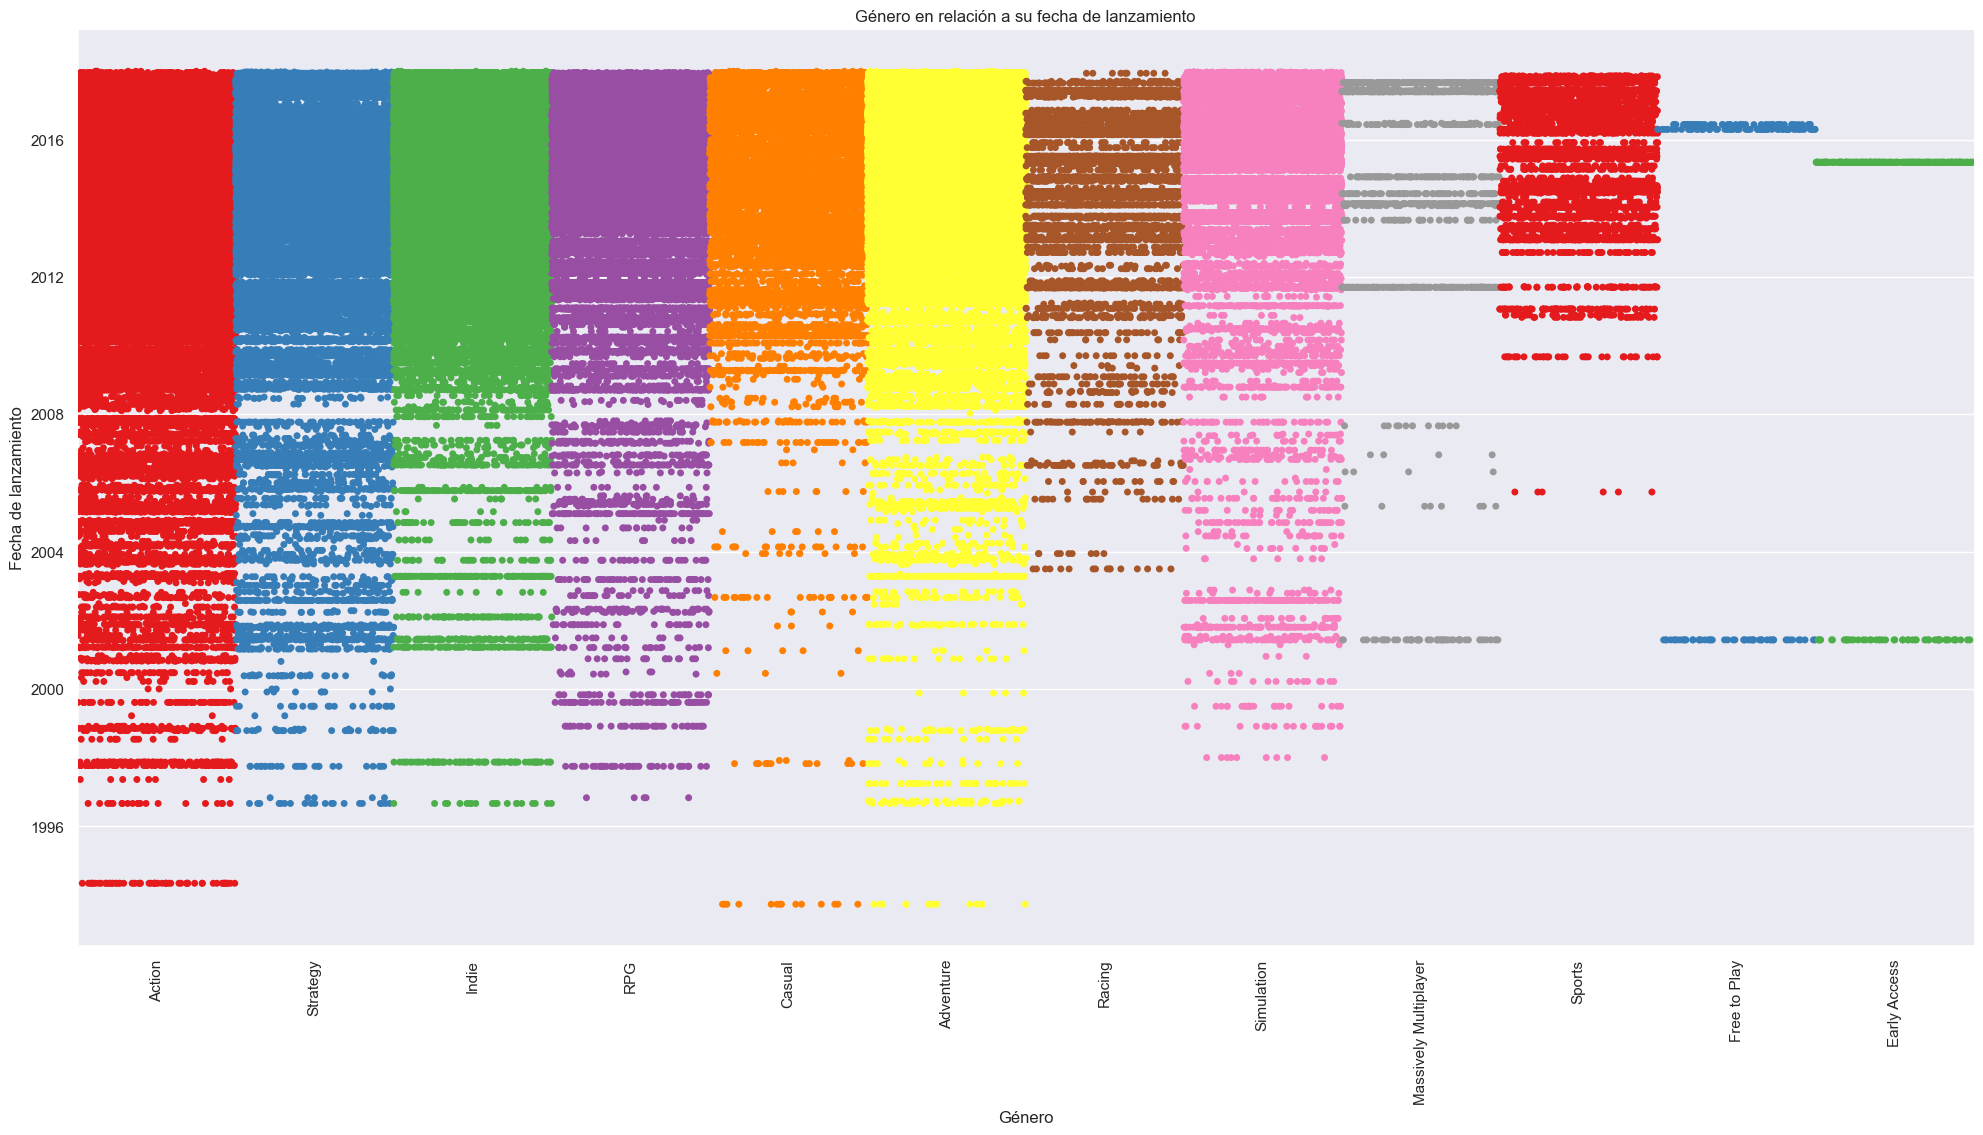

In [31]:
# Creamos el catplot para las variables detalladas
plt.figure(figsize=(12, 12))
sns.catplot(x='genres', y='release_date', data=steam_eda_reduc, jitter=0.5, hue='genres', palette='Set1', height=10, aspect=2)
plt.xticks(rotation=90)
plt.xlabel('Género')
plt.ylabel('Fecha de lanzamiento')
plt.title('Género en relación a su fecha de lanzamiento')
plt.show()

* Podemos observar que los géneros casual y aventuras, fueron los primeros en lanzarse, que entre los años 2008 y 2017 se concentran la mayor cantidad de lanzamientos y que Free to Play y Early Access, se pelean por ser el género menos lanzado.

##### Violinplot para las variables 'genres', 'metascore' y 'early_access'

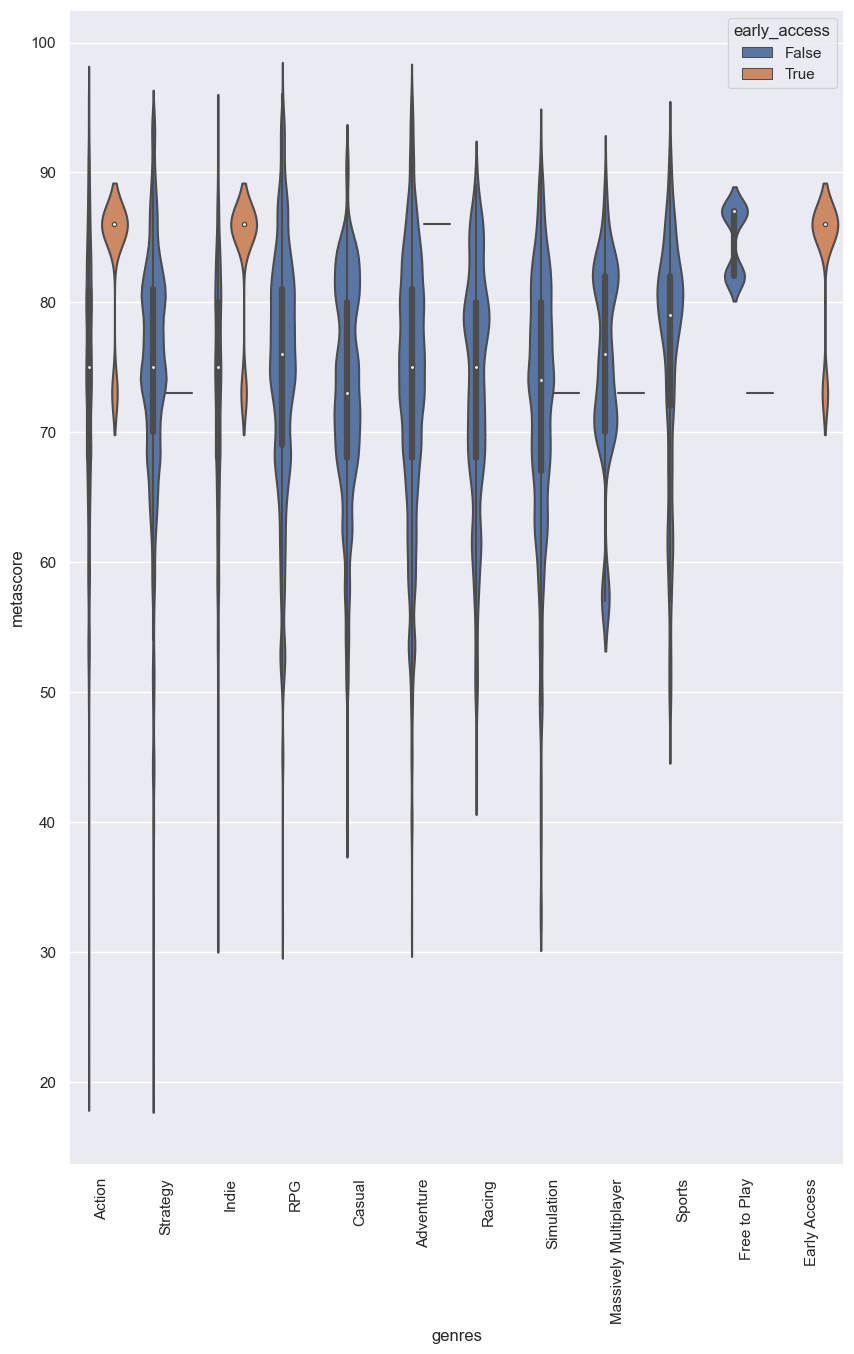

In [32]:
# Usamos un tipo de gráfico boxplot para mostrar los resultados del 'describe' 
plt.figure(figsize=(10, 15))
sns.violinplot(data=steam_eda_reduc, x='genres', y='metascore', hue='early_access')
plt.xticks(rotation=90)
plt.show()

* Al contrario de lo que venimos viendo, resulta que el género Acceso Temprano como así el tipo de acceso temprano, aquí batallan mano a mano en cuanto a su metascore, respecto de géneros como acción e indie, con una concentración cercana al puntaje 87, teniendo a su vez como el género con más variación de puntajes a Action.

##### Histograma para las variables 'price' y 'metascore'

In [33]:
# Inicializamos con una comprobación de la distribución en un pequeño dataframe
steam_eda_reduc[['price', 'metascore']].describe()

,price,metascore
count,310692.000000,310692.000000
mean,17.523818,73.774513
std,10.965952,9.913501
min,0.990000,20.000000
25%,9.990000,68.000000
50%,14.990000,75.000000
75%,19.990000,81.000000
max,99.990000,96.000000


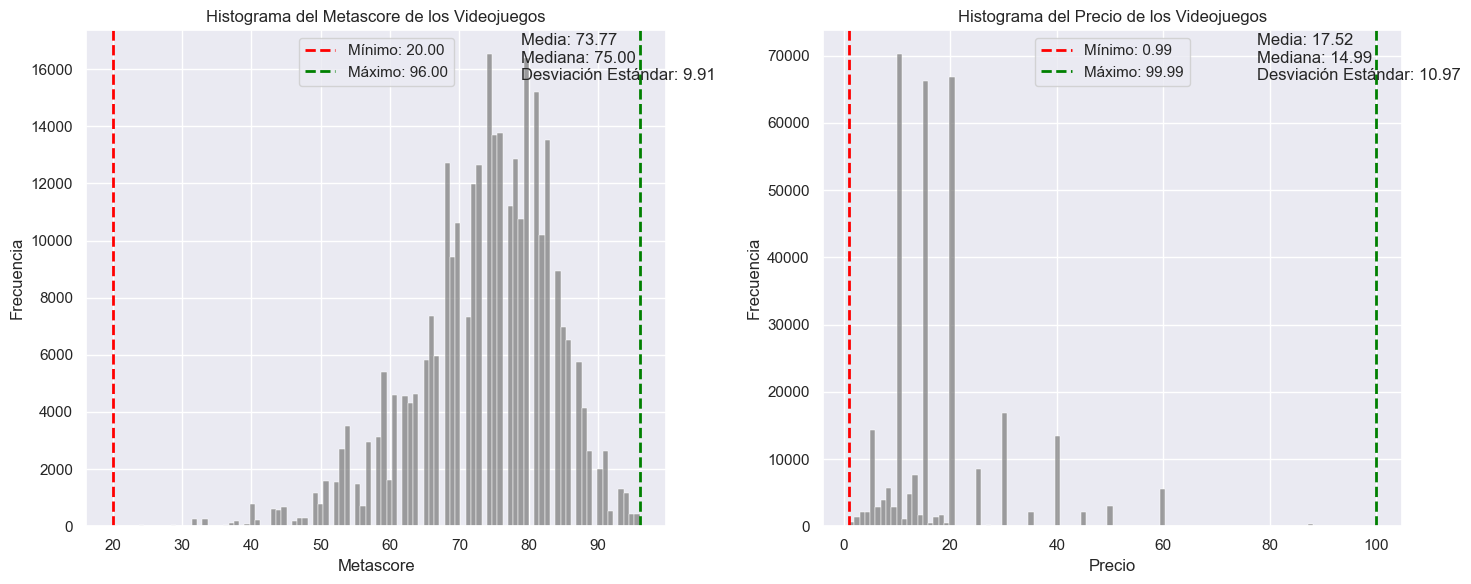

In [34]:
# Nos aseguramos que las variables no contienen valores no numéricos
steam_eda_reduc = steam_eda_reduc.dropna(subset=['price', 'metascore'])
# Convertir las columnas 'price' y 'metascore' al tipo de datos numérico si es necesario (omitir si ya son numéricas)
steam_eda_reduc['price'] = pd.to_numeric(steam_eda_reduc['price'], errors='coerce')
steam_eda_reduc['metascore'] = pd.to_numeric(steam_eda_reduc['metascore'], errors='coerce')
# Creamos una figura con 1 fila y 2 columnas para los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# Histograma de 'price' en el primer subplot
sns.histplot(steam_eda_reduc['price'], bins=100, kde=False, color='gray', ax=ax2)
min_price = steam_eda_reduc['price'].min()
max_price = steam_eda_reduc['price'].max()
ax2.set_xlabel('Precio')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Histograma del Precio de los Videojuegos')
ax2.text(0.75, 0.9, f"Media: {steam_eda_reduc['price'].mean():.2f}\nMediana: {steam_eda_reduc['price'].median():.2f}\nDesviación Estándar: {steam_eda_reduc['price'].std():.2f}",
         transform=ax2.transAxes)
ax2.axvline(min_price, color='red', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_price:.2f}')
ax2.axvline(max_price, color='green', linestyle='dashed', linewidth=2, label=f'Máximo: {max_price:.2f}')
ax2.legend()
# Histograma de 'metascore' en el segundo subplot
sns.histplot(steam_eda_reduc['metascore'], bins=100, kde=False, color='gray', ax=ax1)
min_metascore = steam_eda_reduc['metascore'].min()
max_metascore = steam_eda_reduc['metascore'].max()
ax1.set_xlabel('Metascore')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Histograma del Metascore de los Videojuegos')
ax1.text(0.75, 0.9, f"Media: {steam_eda_reduc['metascore'].mean():.2f}\nMediana: {steam_eda_reduc['metascore'].median():.2f}\nDesviación Estándar: {steam_eda_reduc['metascore'].std():.2f}",
         transform=ax1.transAxes)
ax1.axvline(min_metascore, color='red', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_metascore:.2f}')
ax1.axvline(max_metascore, color='green', linestyle='dashed', linewidth=2, label=f'Máximo: {max_metascore:.2f}')
ax1.legend()
# Ajustamos los subplots para evitar superposición de etiquetas
plt.tight_layout()
# Mostramos el gráfico
plt.show()

* Ambos histogramas resultan muy claros a la lectura, no obstante ser notorios como la mayoria de los gaps en la variables metascore parecieran aparecen cada tres marcas de puntajes.

##### Scatterplot para las variables 'price' y 'metascore'

Coeficiente de la línea de regresión (pendiente): 20.77
Término independiente de la línea de regresión (intercepto): 6.86


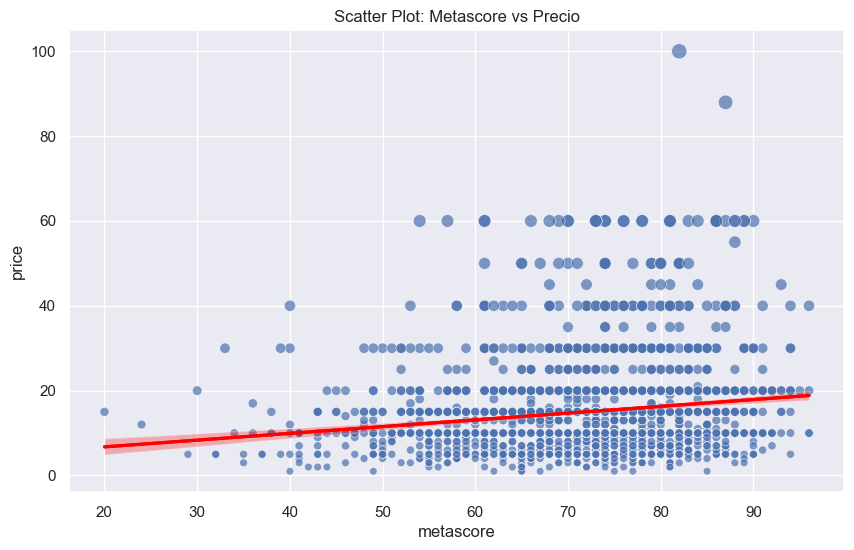

In [35]:
# Creamos el scatter plot para las variables de interés
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_steam, x='metascore', y='price', size='price', sizes=(30, 120), palette='viridis', alpha=0.7, legend=False)
plt.xlabel('Metascore')
plt.ylabel('Precio')
plt.title('Scatter Plot: Metascore vs Precio')
# Agregamos una la línea de varianza
reg_plot = sns.regplot(data=data_steam, x='metascore', y='price', scatter=False, color='red')
# Obtenenemos los resultados de la regresión lineal
x = data_steam['metascore']
y = data_steam['price']
model = sns.regplot(data=data_steam, x='metascore', y='price', scatter=False, color='red')
slope, intercept = model.get_lines()[0].get_data()
# Imprimimos los resultados de la regresión lineal
print(f"Coeficiente de la línea de regresión (pendiente): {slope[1]:.2f}")
print(f"Término independiente de la línea de regresión (intercepto): {intercept[1]:.2f}")
# Mostramos el gráfico
plt.show()

* Con lo visualizado, podemos concluir que para cada aumento de una unidad en el metascore, el precio del juego aumenta en promedio en 20.77 unidades, teniendo como punto de partida que cuando el metascore sea cero, el precio sería de aproximadamente 6.86 unidades.

##### Boxplot entre las variables 'price', 'metascore' y 'early_access'

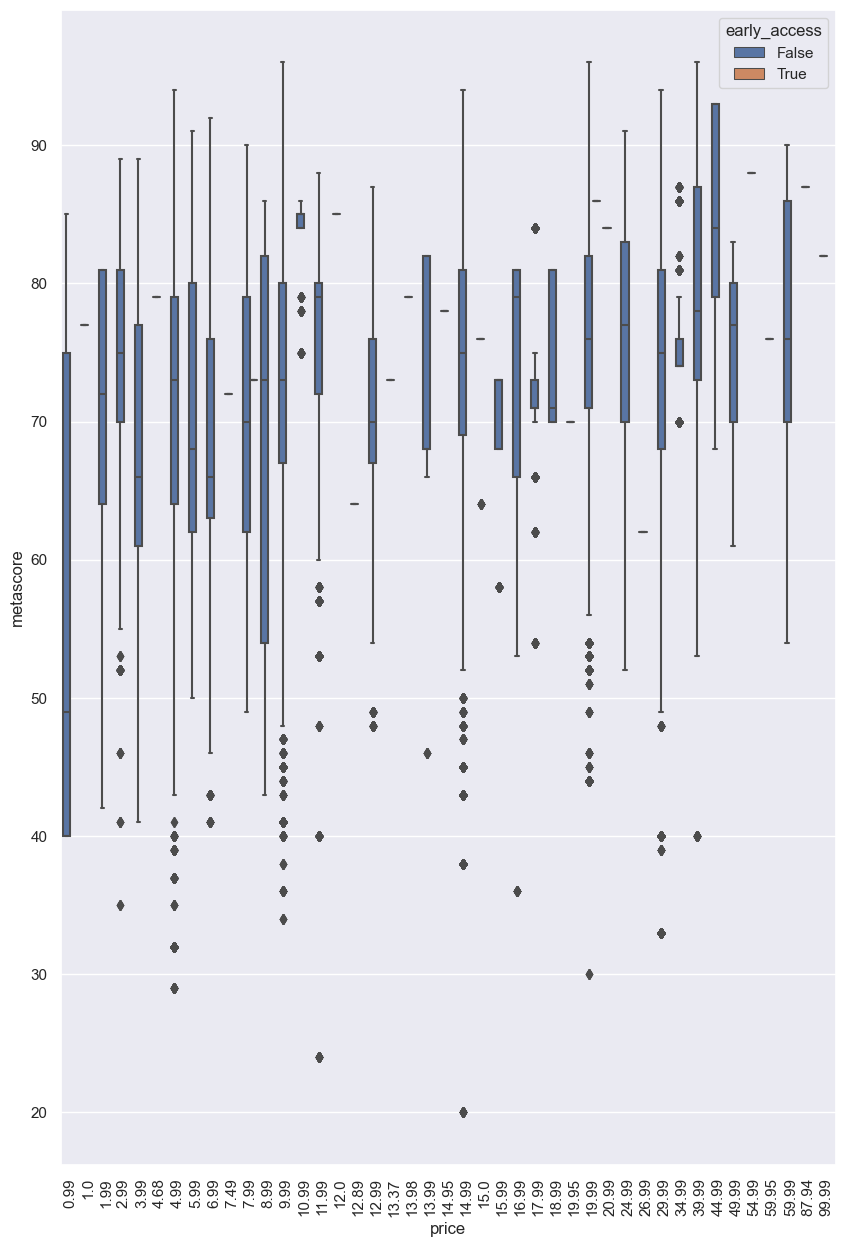

In [36]:
# Creamos el boxplot de las variables de interés  
plt.figure(figsize=(10, 15))
sns.boxplot(data=steam_eda_reduc, x='price', y='metascore', hue='early_access')
plt.xticks(rotation=90)
plt.show()

* Claro resulta, luego del boxplot, que se presentan valores únicos y atípicos, en general, en unidades de metascore por debajo de 60 en la mayoría de las unidades de precio, manteniéndose un constante volumen de puntajes entre los 65 y 80 puntos.

##### Boxplot entre las variables 'genres', 'price' y 'early_access'

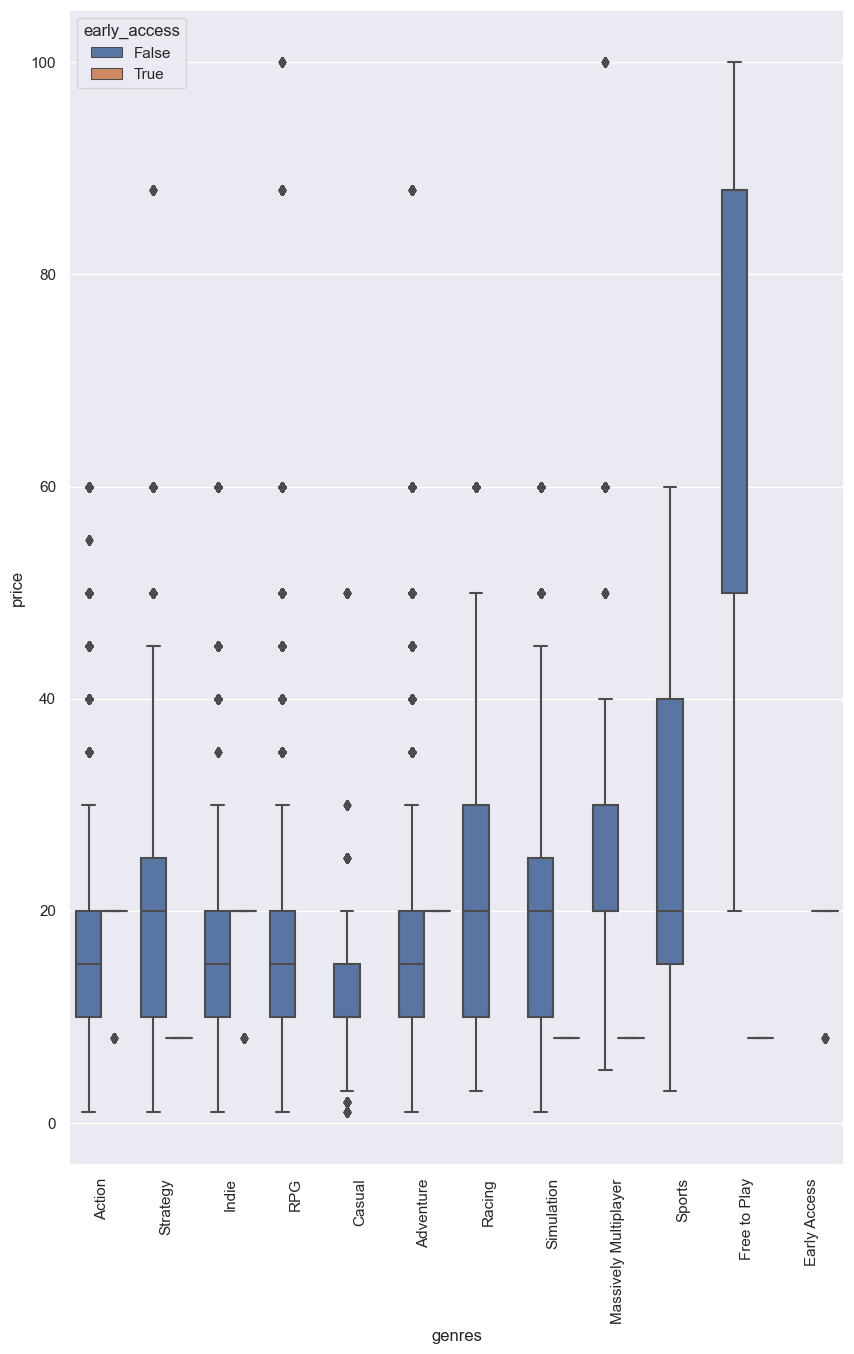

In [37]:
# Creamos el boxplot de las variables de interés  
plt.figure(figsize=(10, 15))
sns.boxplot(data=steam_eda_reduc, x='genres', y='price', hue='early_access')
plt.xticks(rotation=90)
plt.show()

* Es interesante ver, en este segundo boxplot que, al comparar los géneros con el precio, la visualización se invierte -en relación al boxplot anterior- casi a un 100%. Aquí observamos que los valores únicos o atípicos se dan por encima de los 20 puntos de precio, generándose la mayor concentración entre los 10 y los 25. Como punto de atención, es llamativo ver que en los géneros Free To Play, el volumen de precios es más elevado que en los demás géneros. 